In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "bert-base-german-cased"

# DataSet

In [2]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  

In [3]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [4]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [5]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [6]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob=0.4,
                                                      hidden_dropout_prob=0.4
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.4, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [7]:
batch_size = 36
OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)

epochs = 30

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [8]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [9]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.7144219561627037
Validation loss: 1.603265643119812
F1 Score (Weighted): 0.2808579602530261


Epoch 2:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.5985732956936485
Validation loss: 1.4520692066712813
F1 Score (Weighted): 0.37445688553936635


Epoch 3:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.47025504028588
Validation loss: 1.3263973647897893
F1 Score (Weighted): 0.42795315995967775


Epoch 4:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.3744560710170812
Validation loss: 1.2604126225818286
F1 Score (Weighted): 0.48445984373243545


Epoch 5:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.273227331931131
Validation loss: 1.201856862414967
F1 Score (Weighted): 0.48452470637085965


Epoch 6:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.1920051762932224
Validation loss: 1.1120460900393399
F1 Score (Weighted): 0.5683443559277652


Epoch 7:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.140517296498282
Validation loss: 1.0720214518633755
F1 Score (Weighted): 0.5649416337148715


Epoch 8:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.0984664935814707
Validation loss: 1.073344517837871
F1 Score (Weighted): 0.5759661128521208


Epoch 9:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.0566410464152955
Validation loss: 1.0701494108546863
F1 Score (Weighted): 0.5754913099070964


Epoch 10:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 10
Training loss: 1.0411315905420404
Validation loss: 1.043688183481043
F1 Score (Weighted): 0.5954425005224292


Epoch 11:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 11
Training loss: 1.016794480775532
Validation loss: 1.0516243739561602
F1 Score (Weighted): 0.6082863767730018


Epoch 12:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.9754644234975179
Validation loss: 1.0194863731210881
F1 Score (Weighted): 0.6183274120421979


Epoch 13:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.9261514513116134
Validation loss: 1.0536703738299282
F1 Score (Weighted): 0.6145319010437466


Epoch 14:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.9201921318706713
Validation loss: 1.0193360989744014
F1 Score (Weighted): 0.6273614372482332


Epoch 15:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.8844982396092331
Validation loss: 0.9950188398361206
F1 Score (Weighted): 0.627115570824205


Epoch 16:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.8719762940155832
Validation loss: 0.9604159160093828
F1 Score (Weighted): 0.6417342212989037


Epoch 17:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.8514377276102701
Validation loss: 0.9855711189183322
F1 Score (Weighted): 0.6282016523387971


Epoch 18:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.82756251671858
Validation loss: 0.927664502100511
F1 Score (Weighted): 0.6532412929830043


Epoch 19:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.8190179174406487
Validation loss: 0.9269387071782892
F1 Score (Weighted): 0.6717363925774595


Epoch 20:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.7937982354247779
Validation loss: 0.9180340441790494
F1 Score (Weighted): 0.6598083401327671


Epoch 21:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.7969866792360941
Validation loss: 0.9702369733290239
F1 Score (Weighted): 0.6520075347045068


Epoch 22:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.7791639566421509
Validation loss: 0.9568353349512274
F1 Score (Weighted): 0.6432235564678339


Epoch 23:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.7746646163756388
Validation loss: 0.9427690505981445
F1 Score (Weighted): 0.6692855292467165


Epoch 24:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.7612094481786092
Validation loss: 0.9174649011005055
F1 Score (Weighted): 0.6616550271173854


Epoch 25:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.7449157211864204
Validation loss: 0.9267781160094521
F1 Score (Weighted): 0.679768408671393


Epoch 26:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.7615349711033336
Validation loss: 0.9252582354979082
F1 Score (Weighted): 0.6772900101995387


Epoch 27:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.7491666282478132
Validation loss: 0.9051487391645258
F1 Score (Weighted): 0.6890609742196507


Epoch 28:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.7547401252545809
Validation loss: 0.9024649370800365
F1 Score (Weighted): 0.6829991060435522


Epoch 29:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.7506573686474248
Validation loss: 0.9070123163136569
F1 Score (Weighted): 0.6800810600570552


Epoch 30:   0%|          | 0/57 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.7333645784018332
Validation loss: 0.9031890630722046
F1 Score (Weighted): 0.6802602193210567


# Testing best model

In [10]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.2808579602530261), (2, 0.37445688553936635), (3, 0.42795315995967775), (4, 0.48445984373243545), (5, 0.48452470637085965), (6, 0.5683443559277652), (7, 0.5649416337148715), (8, 0.5759661128521208), (9, 0.5754913099070964), (10, 0.5954425005224292), (11, 0.6082863767730018), (12, 0.6183274120421979), (13, 0.6145319010437466), (14, 0.6273614372482332), (15, 0.627115570824205), (16, 0.6417342212989037), (17, 0.6282016523387971), (18, 0.6532412929830043), (19, 0.6717363925774595), (20, 0.6598083401327671), (21, 0.6520075347045068), (22, 0.6432235564678339), (23, 0.6692855292467165), (24, 0.6616550271173854), (25, 0.679768408671393), (26, 0.6772900101995387), (27, 0.6890609742196507), (28, 0.6829991060435522), (29, 0.6800810600570552), (30, 0.6802602193210567)]


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(0.2551575718596943, 1), (0.3372389606249004, 2), (0.38547533437315956, 3), (0.4325721980972907, 4), (0.4392575950188464, 5), (0.5196640470869757, 6), (0.5212009096282714, 7), (0.5411062015140309, 8), (0.5315258953669436, 9), (0.5542188324078358, 10), (0.572431386230371, 11), (0.5807408374349456, 12), (0.5877481665373908, 13), (0.5949308051646013, 14), (0.5944882956685124, 15), (0.6145786641390609, 16), (0.6016702146639594, 17), (0.6213512832205902, 18), (0.6386793306442068, 19), (0.6262099251573933, 20), (0.6235058122340713, 21), (0.618750761821362, 22), (0.6379673176232836, 23), (0.6257454124026841, 24), (0.6476952952271813, 25), (0.6482228584965445, 26), (0.6556756579000685, 27), (0.6497717916513748, 28), (0.6481378047232702, 29), (0.6481378047232702, 30)]


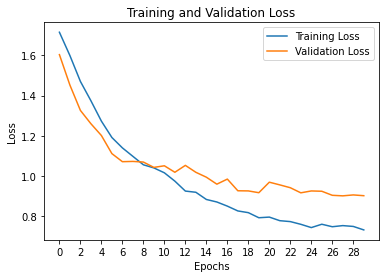

In [11]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()